In [ ]:
# #gpu
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

In [ ]:
# #cpu
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [ ]:
!pip install wandb torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 33.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=c9f793bce03e5ff3bc2263f07e8a6a53c1cde182bd0fcb84ef7fc07eb306e695
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
  Created wheel for pathtools: filename=pathtoo

In [ ]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1-TqjWqiCVhVeAdzDcYUdeMDxBABUmxr0?usp=sharing", quiet=True)

['/content/graph_trainset_sota_financial_pooler_bugfix/processed/data.pt',
 '/content/graph_trainset_sota_financial_pooler_bugfix/processed/pre_filter.pt',
 '/content/graph_trainset_sota_financial_pooler_bugfix/processed/pre_transform.pt']

In [ ]:
gdown.download_folder("https://drive.google.com/drive/folders/1-aZsbmI99aRiZ0TUCmlUfOOAv2Ow8W0Y?usp=sharing", quiet=True)


['/content/graph_testset_sota_financial_pooler_bugfix/processed/data.pt',
 '/content/graph_testset_sota_financial_pooler_bugfix/processed/pre_filter.pt',
 '/content/graph_testset_sota_financial_pooler_bugfix/processed/pre_transform.pt']

In [ ]:
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops ,
)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings("ignore")
import time


import numpy as np
import scipy.sparse as sp
from torch import nn
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
from torch_geometric.nn import SAGEConv, to_hetero
import torch

import matplotlib.pyplot as plt
import torch_geometric.nn as  gnn
from torch_geometric.data  import Data
from torch_geometric.data import HeteroData

from torch.nn import functional as F
import torch
from torch.optim.adamw import AdamW
import time
from argparse import ArgumentParser
import argparse
import wandb
import numpy as np
import random
import os
import datetime
from tqdm import tqdm
generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)


In [ ]:

# """
# https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
# """
from torch_geometric.data  import InMemoryDataset
class WeekGraphs(InMemoryDataset):
    def __init__(self, root, transform=None):
        # if len(data_list) != 0:
          # self.data_list = data_list
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])
# dataset = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_dataset", [])

In [ ]:
train = WeekGraphs("./graph_trainset_sota_financial_pooler_bugfix")
test = WeekGraphs("./graph_testset_sota_financial_pooler_bugfix")

In [ ]:
train.data["target"].shape

torch.Size([333125])

In [ ]:
from torch_geometric.loader import DataLoader


train_loader = DataLoader(train, batch_size=8)
test_loader = DataLoader(test, batch_size=8, shuffle=False)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, num_layers=2,hidden_size=64, output_size=64, num_steps =10 ):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(num_steps)

    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        x = self.batch_norm1(x)
        out, _ = self.lstm1(x)
        # out, _ = self.lstm2(out)
        out = F.gelu(self.fc1(out[:, -1, :]))
        return out



In [ ]:
class GConv(nn.Module):

    def __init__(self, emb_dim:int=64, num_layers:int=2, encode:bool=True, concat_out:bool=False, device='cpu', dropout=0.2):

        super(GConv,self).__init__()
        self.num_layers = num_layers
        self.gconv_layers = []
        self.norm_layers = []
        self.encode = encode
        for _ in range(num_layers):
            self.gconv_layers.append(gnn.SAGEConv(emb_dim, emb_dim, dropout=dropout, project=True).to(device)) # project=True ()
            if self.encode:
                self.norm_layers.append(nn.LayerNorm(emb_dim).to(device))
        self.gconv_layers = nn.ModuleList(self.gconv_layers)
        self.norm_layers = nn.ModuleList(self.norm_layers)

        self.concat_out = concat_out

    def forward(self, x, edge_index):

        outs = []
        if self.encode:
            outs.append(self.norm_layers[0](self.gconv_layers[0](x, edge_index)))
        else:
            outs.append(self.gconv_layers[0](x, edge_index))
        for i in range(1,self.num_layers):
            if self.encode:
                outs.append(self.norm_layers[i](self.gconv_layers[i](outs[-1], edge_index)))
            else:
                outs.append(self.gconv_layers[i](outs[-1], edge_index))
        if self.concat_out:
            return torch.cat(outs, dim = -1)

        return outs[-1]


class NeuroStock(nn.Module):

  def __init__(self,
               num_timeseries_features=1,
               n_companies=325,
               company_emb_size=32,
               node_emb_size=64,
               article_emb_size=768,
               n_industries=14,
               n_gnn_layers=3,
               graph_metadata:Tuple=None):
    super(NeuroStock, self).__init__()
    """
    company node representation will be a concatenation of its embedding and the output of the timeseries model (in this case it's an LSTM)
    """
    self.num_timeseries_features = num_timeseries_features
    self.n_companies = n_companies
    self.company_emb_size = company_emb_size
    self.node_emb_size = node_emb_size
    self.article_emb_size = article_emb_size
    self.n_industries = n_industries
    self.n_gnn_layers = n_gnn_layers
    self.lstm = LSTM(input_size=num_timeseries_features,  hidden_size=company_emb_size, output_size=company_emb_size).to(torch.float)

    if graph_metadata is None:
      raise("You need to pass HeteroData.metadata()")
    self.company_embedding = nn.Embedding(n_companies, company_emb_size).to(torch.float)
    self.industry_embedding = nn.Embedding(n_industries, node_emb_size).to(torch.float)
    self.project_article = nn.Linear(article_emb_size, node_emb_size).to(torch.float)

    # to_hetero transforms normal gnn aggregation layer to a heterogeneous aggregation layer
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero
    self.g_conv = gnn.to_hetero(GConv(emb_dim=node_emb_size, num_layers=n_gnn_layers), graph_metadata).to(torch.float)

    self.classifier = nn.Sequential(nn.Dropout(0.2),nn.Linear(node_emb_size, 1)).to(torch.float)

  def forward(self, hetero_x:HeteroData):
    hetero_x["article"].x = self.project_article(hetero_x["article"].x)
    companies = self.company_embedding(hetero_x["company"].x)
    # print(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.double).shape, hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float).dtype)
    # company_timeseries is of shape (n_companies*batch_size, n_days, n_features)  the features are "open", "high", "low", "close", "volume"
    companies_timeseries = self.lstm(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float))
    hetero_x["company"].x = torch.cat((companies_timeseries, companies), dim=-1)  #companies are in shape (n_companies*batch_size, node_emb_size)
    hetero_x["industry"].x = self.industry_embedding(hetero_x["industry"].x)
    graph = self.g_conv(hetero_x.x_dict, hetero_x.edge_index_dict)
    out = F.sigmoid(self.classifier(graph["company"]))
    return out

  def compute_loss(self, out, target):
    loss = F.binary_cross_entropy(out.reshape(-1), target.float())
    return loss


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
# train_points = [[train[i]["company_timeseries"], train[i]["target"]] for i in range(len(train))]
# test_points = [[test[i]["company_timeseries"], test[i]["target"]] for i in range(len(test))]

train_x = []
train_y = []

for i in range(len(train)):
  for company_idx, company in enumerate(train[i]["company_timeseries"]):
    train_x.append(company[:,-2].reshape(-1).numpy().tolist())
    train_y.append(train[i]["target"][company_idx].item())

test_x = []
test_y = []

for i in range(len(test)):
  for company_idx, company in enumerate(test[i]["company_timeseries"]):
    test_x.append(company[:,-2].reshape(-1).numpy().tolist())
    test_y.append(test[i]["target"][company_idx].item())

(1025, 2)

In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
train_x.shape

(333125, 50)

In [ ]:
from catboost import Pool
cat = CatBoostClassifier(iterations=40, learning_rate=0.03, depth=11, , eval_metric="AUC")
cat.fit(train_x, train_y, eval_set=Pool(test_x, test_y))

0:	test: 0.5302544	best: 0.5302544 (0)	total: 120ms	remaining: 4.69s
1:	test: 0.5306547	best: 0.5306547 (1)	total: 297ms	remaining: 5.65s
2:	test: 0.5305034	best: 0.5306547 (1)	total: 434ms	remaining: 5.36s
3:	test: 0.5307361	best: 0.5307361 (3)	total: 551ms	remaining: 4.96s
4:	test: 0.5307014	best: 0.5307361 (3)	total: 682ms	remaining: 4.78s
5:	test: 0.5305542	best: 0.5307361 (3)	total: 800ms	remaining: 4.53s
6:	test: 0.5303204	best: 0.5307361 (3)	total: 922ms	remaining: 4.35s
7:	test: 0.5303190	best: 0.5307361 (3)	total: 1.05s	remaining: 4.21s
8:	test: 0.5305503	best: 0.5307361 (3)	total: 1.3s	remaining: 4.46s
9:	test: 0.5305009	best: 0.5307361 (3)	total: 1.53s	remaining: 4.6s
10:	test: 0.5304272	best: 0.5307361 (3)	total: 1.79s	remaining: 4.71s
11:	test: 0.5306500	best: 0.5307361 (3)	total: 2.05s	remaining: 4.79s
12:	test: 0.5306372	best: 0.5307361 (3)	total: 2.3s	remaining: 4.77s
13:	test: 0.5306493	best: 0.5307361 (3)	total: 2.51s	remaining: 4.67s
14:	test: 0.5306184	best: 0.53073

In [ ]:
train_

In [ ]:
import wandb

from   tqdm import tqdm
wandb.init(
        project="test_gnn",
        name="test_financial_sota_pooler_bugfix_dim128",
        mode="online")

n_epochs = 50
# warmup_steps=

neurostock = NeuroStock(node_emb_size=128, company_emb_size=64, graph_metadata=train[0].metadata())
neurostock.to('cuda')
device = next(neurostock.parameters()).device
optimizer =  torch.optim.AdamW(neurostock.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1,  total_iters=warmup_steps)
for e in tqdm(range(n_epochs)):
    train_losses= []
    neurostock.train()
    train_outs = []
    train_targets = []
    for batch  in train_loader:
        # with torch.autocast(device_type="cuda", dtype=torch.float16):
        batch = batch.to(device)
        out = neurostock(batch)
        train_outs.append(out.cpu().detach().reshape(-1))
        train_targets.append(batch["target"].cpu().detach().reshape(-1))
        loss = neurostock.compute_loss(out, batch["target"])
        optimizer.zero_grad()
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    neurostock.eval()
    valid_losses = []
    # continue
    valid_outs = []
    valid_targets = []
    with torch.no_grad():
        for batch  in test_loader:

          batch = batch.to(device)
          out = neurostock(batch)
          valid_outs.append(out.reshape(-1).cpu().detach())
          valid_targets.append(batch["target"].reshape(-1).cpu().detach())
          loss = neurostock.compute_loss(out, batch["target"])
          valid_losses.append(loss.item())

    valid_outs = torch.cat(valid_outs).numpy()
    valid_targets = torch.cat(valid_targets).numpy()
    valid_acc = ((valid_outs >= 0.5) == valid_targets).mean()
    train_outs = torch.cat(train_outs).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_acc = ((train_outs >= 0.5) == train_targets).mean()
    wandb.log({
          "train_loss" : np.mean(train_losses),
          "valid_loss" : np.mean(valid_losses),
          "valid_acc" : valid_acc,
          "train_acc" : train_acc
    })
wandb.finish()


100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


train_acc,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
valid_acc,▄▂▂▁▁▂▃▃▅▆▆▆▇▇█▇▇█▇██▇▇▇▇▇▇▇██▇████▇▇▇▆▆
valid_loss,▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▅▆█▇
train_acc,0.5502
train_loss,0.68176
valid_acc,0.51737
valid_loss,0.6993


325.0

In [ ]:
batch.date

[Timestamp('2020-02-20 00:00:00')]

In [ ]:
neurostock.eval()
valid_losses = []
# continue
valid_outs = []
valid_targets = []
with torch.no_grad():
    for batch  in test_loader:

      batch = batch.to(device)
      out = neurostock(batch)
      outs = torch.cat([ k.unsqueeze(0) for k in out.chunk(batch["company"].ptr.shape[0]-1)]).squeeze(-1).cpu().detach()
      targets = torch.cat([ k.unsqueeze(0) for k in batch["target"].chunk(batch["company"].ptr.shape[0]-1)]).cpu().detach()
      valid_outs.append(outs)
      valid_targets.append(targets)
      loss = neurostock.compute_loss(out, batch["target"])
      valid_losses.append(loss.item())
valid_outs = torch.cat(valid_outs).numpy()
valid_targets = torch.cat(valid_targets).numpy()


In [ ]:
for k in test_loader:
  break
k

In [ ]:
k.date

[Timestamp('2019-02-13 00:00:00'),
 Timestamp('2019-02-14 00:00:00'),
 Timestamp('2019-02-15 00:00:00'),
 Timestamp('2019-02-19 00:00:00'),
 Timestamp('2019-02-20 00:00:00'),
 Timestamp('2019-02-21 00:00:00'),
 Timestamp('2019-02-22 00:00:00'),
 Timestamp('2019-02-25 00:00:00')]

In [ ]:
targets.shape

torch.Size([1, 325])

In [ ]:
gdown.download_folder("https://drive.google.com/drive/folders/1Iv2dvM27Q11IAY73h4y8ldcymtHcJ-mb?usp=share_link", )

In [ ]:
valid_outs.shape, valid_targets.shape

((257, 325), (257, 325))

(<Axes: >, 0.5192696797366058)

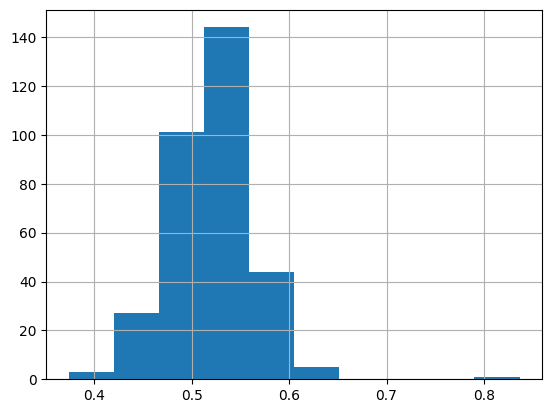

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs >= 0.4) == valid_targets).mean(0)
pd.Series(acc_per_company).hist(), acc_per_company.mean()

<Axes: >

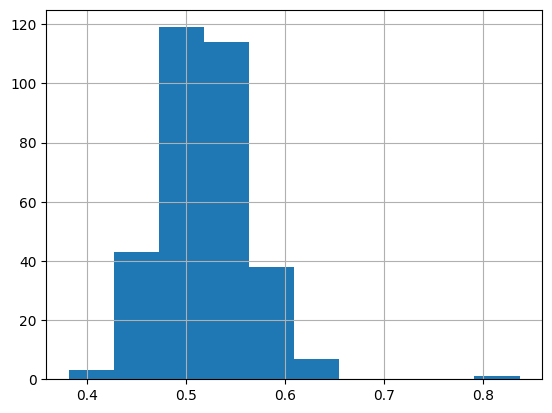

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs >= 0.5) == valid_targets).mean(0)
pd.Series(acc_per_company).hist()

In [ ]:
acc_per_company[acc_per_company.argsort()[-20:]]

array([0.57198444, 0.57587549, 0.57587549, 0.57976654, 0.58365759,
       0.58365759, 0.58365759, 0.58754864, 0.58754864, 0.58754864,
       0.58754864, 0.59533074, 0.59922179, 0.60311284, 0.60700389,
       0.60700389, 0.61089494, 0.61089494, 0.63035019, 0.83657588])

In [ ]:
import pandas as pd
nasdaq_screener = pd.read_csv("raw_data/nasdaq_screener.csv")
news_df = pd.read_csv("raw_data/processed_news_df.csv")
news_df["mentioned_companies"] = news_df["mentioned_companies"].apply(lambda x: x[1:-1].replace("'","").replace(" ", "").split(","))
stock_df = pd.read_csv("raw_data/processed_stock_df.csv")

In [ ]:
company_to_index["MAT"]

295

In [ ]:
test[200]["target"][295]

tensor(1)

In [ ]:
targets.chunk()

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
         0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 0, 0

In [ ]:
stock_df

,Unnamed: 0,symbol,<PER>,dateOfPrice,<TIME>,open,high,low,close,volume,<OPENINT>
0,2368,CVV,D,2014-12-26,0,14.80000,14.8480,14.21000,14.22000,1.210800e+04,0
1,4007,NVDA,D,2014-12-26,0,4.94082,4.9721,4.92834,4.94531,5.479256e+06,0
2,2475,HAIN,D,2014-12-26,0,58.81500,59.3300,58.57500,59.26000,4.231780e+05,0
3,2475,ENTG,D,2014-12-26,0,12.94190,12.9998,12.87410,12.89400,3.584945e+05,0
4,2475,COLM,D,2014-12-26,0,41.15110,41.5683,40.97800,41.22520,3.083397e+05,0
...,...,...,...,...,...,...,...,...,...,...,...
415704,3770,HST,D,2020-02-20,0,16.81500,16.8150,16.18490,16.66460,1.091273e+07,0
415705,3770,CME,D,2020-02-20,0,191.30800,192.5290,188.29600,192.26200,1.743956e+06,0
415706,4932,MRVL,D,2020-02-20,0,24.80020,25.1233,24.38520,24.77020,5.862125e+06,0
415707,9613,MAT,D,2020-02-20,0,13.05000,13.2850,13.01000,13.25000,4.558237e+06,0


In [ ]:
industry_to_index = {k : v for v,k in enumerate(nasdaq_screener["Sector"].unique()) }
company_to_index = {k :v for v,k in zip(range(news_df["symbol"].nunique()), news_df["symbol"].unique()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse

In [ ]:
nasdaq_screener[nasdaq_screener["Symbol"].isin(best_acc_companies)]

<Axes: >

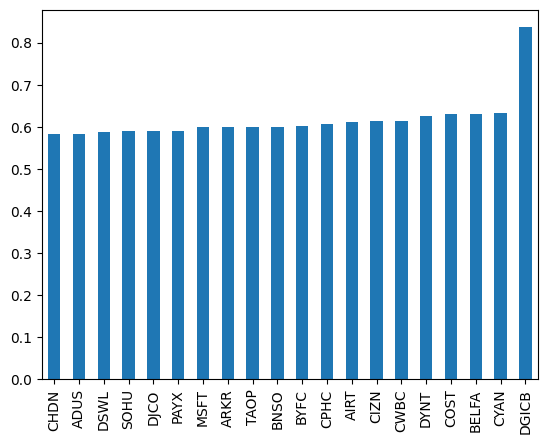

In [ ]:
best_acc_companies = [index_to_company[k] for k in acc_per_company.argsort()[-20:]]
best_acc_companies
pd.Series(data=acc_per_company[acc_per_company.argsort()[-20:]], index=best_acc_companies).plot.bar()

In [ ]:
news_df["symbol"].value_counts()

AAPL     18777
MSFT      7574
AMZN      6136
GOOGL     4852
TSLA      4097
         ...  
CIZN         1
BELFA        1
DMLP         1
ATLO         1
CZNC         1
Name: symbol, Length: 325, dtype: int64

In [ ]:
news_df[news_df["symbol"].isin(best_acc_companies)]["symbol"].value_counts()

MSFT     7574
COST      465
PAYX      107
CHDN       90
SOHU       46
ADUS       32
TAOP       14
CYAN        7
DYNT        7
DGICB       6
BYFC        5
ARKR        5
DJCO        5
DSWL        3
CPHC        3
CWBC        3
BNSO        2
AIRT        1
BELFA       1
CIZN        1
Name: symbol, dtype: int64